## 1- Gathering Data

In [1]:
# Importing the required libraries

import pandas as pd
import numpy as np
import requests
import os
import tweepy
import time
import json
import re
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#### a- Twitter archive


In [2]:
# Importing the twitter-archive-enhanced.csv file into a DataFrame.
# This file is provided by Udacity.
twitter_archive = pd.read_csv("twitter-archive-enhanced.csv", sep="," )

#### b-  Image predictions

In [3]:
# Downloading the tweet image predictions from Udacity's servers:
tweet_image_prediction_url = "https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"
response = requests.get(tweet_image_prediction_url)

In [4]:
#save the image-predictions.tsv file
with open(os.path.join(os.getcwd(), 
         tweet_image_prediction_url.split('/')[-1]), mode='wb') as file:
    file.write(response.content)

In [5]:
#Import the predictions tsv file
twitter_images = pd.read_csv("image-predictions.tsv", 
                     sep="\t" ) 
#show the data
twitter_images.head(2)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True


#### c- Gather Tweets from Twitter API

In [6]:
#we need to fetch the tweets from the Twitter API

In [7]:
#authentication

consumer_key = '.....'
consumer_secret = '.....'
access_token = '.....'
access_secret = '.....'

In [8]:
#creating an OAuthHandler instance...
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)

In [9]:
#get the access to the Twitter API.
auth.set_access_token(access_token, access_secret)

In [10]:
#create an API object that we are going to use
api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

In [11]:
'''
txt_file = open('tweet-json.txt','w')
#txt_file.write('tweet_id retweet_count favorite_count created_at''\n')
for tweet_id in twitter_archive.tweet_id:
    try:
    
        tweet_info = api.get_status(tweet_id, tweet_mode='extended')
        retweet_count = tweet_info.retweet_count
        print(tweet_id)
        favorite_count = tweet_info.favorite_count
        created_at = tweet_info.created_at
        txt_file.write(tweet_id+''+str(retweet_count)+''+str(favorite_count)+''+created_at+'\n')
    except Exception as e:
        print('Failed')
txt_file.close()

'''

"\ntxt_file = open('tweet-json.txt','w')\n#txt_file.write('tweet_id retweet_count favorite_count created_at''\n')\nfor tweet_id in twitter_archive.tweet_id:\n    try:\n    \n        tweet_info = api.get_status(tweet_id, tweet_mode='extended')\n        retweet_count = tweet_info.retweet_count\n        print(tweet_id)\n        favorite_count = tweet_info.favorite_count\n        created_at = tweet_info.created_at\n        txt_file.write(tweet_id+''+str(retweet_count)+''+str(favorite_count)+''+created_at+'\n')\n    except Exception as e:\n        print('Failed')\ntxt_file.close()\n\n"

In [12]:
#Reading the tweet-json.txt file and add all into a list
with open('tweet-json.txt') as file:
    my_list_status = []
    for line in file:
        my_list_status.append(json.loads(line))

#using json_normalize to convert json keys to columns 
from pandas.io.json import json_normalize
tweet_df = pd.DataFrame.from_dict(json_normalize(my_list_status), orient='columns')



In [13]:
#create a DataFrame from the tweet_json.txt file and select columns needed for analysis
columns_needed = ['id' , 'retweet_count' , 'favorite_count', 'created_at']
tweet_df_json = tweet_df[columns_needed]


#rename id column to tweet_id
tweet_df_json.rename(columns = {'id':'tweet_id'} , inplace=True)

tweet_df_json.head()

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:2746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


,tweet_id,retweet_count,favorite_count,created_at
0,892420643555336193,8853,39467,Tue Aug 01 16:23:56 +0000 2017
1,892177421306343426,6514,33819,Tue Aug 01 00:17:27 +0000 2017
2,891815181378084864,4328,25461,Mon Jul 31 00:18:03 +0000 2017
3,891689557279858688,8964,42908,Sun Jul 30 15:58:51 +0000 2017
4,891327558926688256,9774,41048,Sat Jul 29 16:00:24 +0000 2017


## 2- Assess Data

### a- twitter_archive table:

In [14]:
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

frist we satart to looking for missing records, there is some in the expanded_urls column but I think its replies.
Also, we have to check duplicated ID.

In [15]:
##know how many retweet in the df
print("The number of retweets in the dataframe is: {}".format (  (twitter_archive[~twitter_archive.retweeted_status_id.isnull()]).count()[0] ) )



The number of retweets in the dataframe is: 181


In [16]:
twitter_archive[twitter_archive['expanded_urls'].isnull()].loc[:,['expanded_urls', 
                                                                  'in_reply_to_status_id', 
                                                                  'in_reply_to_user_id',
                                                                 'retweeted_status_id']]

,expanded_urls,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id
30,NaN,8.862664e+17,2.281182e+09,NaN
55,NaN,8.816070e+17,4.738443e+07,NaN
64,NaN,8.795538e+17,3.105441e+09,NaN
113,NaN,8.707262e+17,1.648776e+07,NaN
148,NaN,8.634256e+17,7.759620e+07,NaN
179,NaN,8.571567e+17,1.806710e+08,NaN
185,NaN,NaN,NaN,8.563302e+17
186,NaN,8.562860e+17,2.792810e+08,NaN
188,NaN,8.558616e+17,1.943518e+08,NaN
189,NaN,8.558585e+17,1.361572e+07,NaN


It seems only 4 from the non-url tweets are not replies. 
which are 185 , 375, 707 and 1445
It is only a few tweets that are reples so there is no need to drop these colunms

In [17]:
#check for duplicate id
twitter_archive['tweet_id'].duplicated().sum()

0

In [18]:
# View rows to know where the value of 'name' is lowercase as the a proper dog name is capitalized
twitter_archive.loc[(twitter_archive['name'].str.islower())]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
22,887517139158093824,NaN,NaN,2017-07-19 03:39:09 +0000,"<a href=""http://twitter.com/download/iphone"" r...",I've yet to rate a Venezuelan Hover Wiener. Th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/887517139...,14,10,such,None,None,None,None
56,881536004380872706,NaN,NaN,2017-07-02 15:32:16 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a pupper approaching maximum borkdrive...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/881536004...,14,10,a,None,None,pupper,None
118,869988702071779329,NaN,NaN,2017-05-31 18:47:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: We only rate dogs. This is quit...,8.591970e+17,4.196984e+09,2017-05-02 00:04:57 +0000,https://twitter.com/dog_rates/status/859196978...,12,10,quite,None,None,None,None
169,859196978902773760,NaN,NaN,2017-05-02 00:04:57 +0000,"<a href=""http://twitter.com/download/iphone"" r...",We only rate dogs. This is quite clearly a smo...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/859196978...,12,10,quite,None,None,None,None
193,855459453768019968,NaN,NaN,2017-04-21 16:33:22 +0000,"<a href=""http://twitter.com/download/iphone"" r...","Guys, we only rate dogs. This is quite clearly...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/855459453...,12,10,quite,None,None,None,None
335,832645525019123713,NaN,NaN,2017-02-17 17:38:57 +0000,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",There's going to be a dog terminal at JFK Airp...,NaN,NaN,NaN,http://us.blastingnews.com/news/2017/02/jfk-an...,10,10,not,None,None,None,None
369,828650029636317184,NaN,NaN,2017-02-06 17:02:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...","Occasionally, we're sent fantastic stories. Th...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/828650029...,14,10,one,None,None,None,None
542,806219024703037440,NaN,NaN,2016-12-06 19:29:28 +0000,"<a href=""http://twitter.com/download/iphone"" r...",We only rate dogs. Please stop sending in non-...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/806219024...,11,10,incredibly,None,None,None,None
649,792913359805018113,NaN,NaN,2016-10-31 02:17:31 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a perfect example of someone who has t...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/792913359...,13,10,a,None,None,None,None
682,788552643979468800,NaN,NaN,2016-10-19 01:29:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Say hello to mad pupper. You kn...,7.363926e+17,4.196984e+09,2016-05-28 03:04:00 +0000,"https://vine.co/v/iEggaEOiLO3,https://vine.co/...",13,10,mad,None,None,pupper,None


In [19]:
#count number of numerator under 10 
twitter_archive[twitter_archive['rating_numerator'] < 10].count()

tweet_id                      440
in_reply_to_status_id          12
in_reply_to_user_id            12
timestamp                     440
source                        440
text                          440
retweeted_status_id             9
retweeted_status_user_id        9
retweeted_status_timestamp      9
expanded_urls                 430
rating_numerator              440
rating_denominator            440
name                          440
doggo                         440
floofer                       440
pupper                        440
puppo                         440
dtype: int64

In [20]:
#count number of denominator != 10
twitter_archive[twitter_archive['rating_denominator'] != 10].count()

tweet_id                      23
in_reply_to_status_id          5
in_reply_to_user_id            5
timestamp                     23
source                        23
text                          23
retweeted_status_id            1
retweeted_status_user_id       1
retweeted_status_timestamp     1
expanded_urls                 19
rating_numerator              23
rating_denominator            23
name                          23
doggo                         23
floofer                       23
pupper                        23
puppo                         23
dtype: int64

### twitter_archive quality summary:

- Retweets present in the dataset (we only want original tweets with images)
- Columns relevant to retweets and replies needs to be dropped 
- Erroneous datatype for tweet_id
- Timestamp have to changed to a uniform date type
- 23 rating denominator not on 10
- 440 numerator below to 10
- doggo, floofer, pupper and puppo have None string we have to convert it to NaN
- Incorrect dog names
- Missing values in 'name' 

### Tidiness summary:

- Four variables (doggo, floofer, pupper, puppo) should be merged in one column
- Timestamp should be split into date and time
- Merge all 3 dataframes into one.




### 2) image_predictions


In [21]:
#view
twitter_images

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


It shown that many of the dog breed names are in lowercase in the p1, the p2 and the p3 columns. 
so, we need to capitalize them.
Also, there are columns with non descriptive names such as (p1, p1_conf, p1_dog, p2, p2_conf, p2_dog, p3, p3_conf, p3_dog) 

In [22]:
#take look
twitter_images.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [23]:
#check duplicate id 
twitter_images.duplicated().sum()

0

#### twitter_images quality summary:

- Erroneous datatype for tweet_id.
- Lowercase dog breed names
- Non-descriptive column names for several variables.

### 3) tweet_df_json

In [24]:
#view
tweet_df_json

,tweet_id,retweet_count,favorite_count,created_at
0,892420643555336193,8853,39467,Tue Aug 01 16:23:56 +0000 2017
1,892177421306343426,6514,33819,Tue Aug 01 00:17:27 +0000 2017
2,891815181378084864,4328,25461,Mon Jul 31 00:18:03 +0000 2017
3,891689557279858688,8964,42908,Sun Jul 30 15:58:51 +0000 2017
4,891327558926688256,9774,41048,Sat Jul 29 16:00:24 +0000 2017
5,891087950875897856,3261,20562,Sat Jul 29 00:08:17 +0000 2017
6,890971913173991426,2158,12041,Fri Jul 28 16:27:12 +0000 2017
7,890729181411237888,16716,56848,Fri Jul 28 00:22:40 +0000 2017
8,890609185150312448,4429,28226,Thu Jul 27 16:25:51 +0000 2017
9,890240255349198849,7711,32467,Wed Jul 26 15:59:51 +0000 2017


In [25]:
tweet_df_json.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 4 columns):
tweet_id          2354 non-null int64
retweet_count     2354 non-null int64
favorite_count    2354 non-null int64
created_at        2354 non-null object
dtypes: int64(3), object(1)
memory usage: 73.6+ KB


#### df_tweet_json quality summary:

- tweet_id has to be a string
- Missing columns: favorite_count and retweet_count

## 3) clean_data 

In [26]:
#Backup data file

twitter_archive_clean = twitter_archive.copy()
twitter_images_clean = twitter_images.copy()
tweet_df_json_clean = tweet_df_json.copy()



### 1) from twitter_archive


###  Define

Retweets present in the dataset (we only want original tweets with images)
Use the 'retweed_status_id' to drop retweets

### code

In [27]:
twitter_archive = twitter_archive[twitter_archive.retweeted_status_id.isnull()]

print("After cleaning, the number of retweets in the dataframe is:  {} ".format (  (twitter_archive[~twitter_archive.retweeted_status_id.isnull()]).count()[0] ) )




After cleaning, the number of retweets in the dataframe is:  0 


#### Columns relevant to retweets and replies needs to be dropped 

##### Define
Use pandas.DataFrame.drop to get rid of columns related to retweets and replies.
Drop unneeded columns(retweeted_status_id, retweeted_status_user_id, in_reply_to_status_id, in_reply_to_user_id, retweeted_status_timestamp) from twitter_archive

##### Test

In [28]:
twitter_archive_clean = twitter_archive_clean.drop(['retweeted_status_id', 
                                                    'retweeted_status_user_id', 
                                                    'retweeted_status_timestamp', 
                                                    'in_reply_to_status_id', 
                                                    'in_reply_to_user_id'],
                                                   axis=1)

In [29]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 12 columns):
tweet_id              2356 non-null int64
timestamp             2356 non-null object
source                2356 non-null object
text                  2356 non-null object
expanded_urls         2297 non-null object
rating_numerator      2356 non-null int64
rating_denominator    2356 non-null int64
name                  2356 non-null object
doggo                 2356 non-null object
floofer               2356 non-null object
pupper                2356 non-null object
puppo                 2356 non-null object
dtypes: int64(3), object(9)
memory usage: 221.0+ KB


#### Incorrect names - lowercase name - & missing name 

### Define

There are non-dog names in name column; for instance, there are words like 'a', 'such', 'the' etc. whereas a proper dog name is capitalized.

In [30]:
#frist we have to change lowercase name to None
twitter_archive_clean.loc[twitter_archive_clean.name.str.islower(),'name'] = 'None' 
#then converts all of the None names to NaN
twitter_archive_clean.name = twitter_archive_clean.name.replace('None',np.nan)

### Test

In [31]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 12 columns):
tweet_id              2356 non-null int64
timestamp             2356 non-null object
source                2356 non-null object
text                  2356 non-null object
expanded_urls         2297 non-null object
rating_numerator      2356 non-null int64
rating_denominator    2356 non-null int64
name                  1502 non-null object
doggo                 2356 non-null object
floofer               2356 non-null object
pupper                2356 non-null object
puppo                 2356 non-null object
dtypes: int64(3), object(9)
memory usage: 221.0+ KB


#### Erroneous datatype for tweet_id

##### Define
Convert 'tweed_id' column to string dataype.

In [32]:
twitter_archive_clean['tweet_id'] = twitter_archive_clean['tweet_id'].astype('str')

##### Test

In [33]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 12 columns):
tweet_id              2356 non-null object
timestamp             2356 non-null object
source                2356 non-null object
text                  2356 non-null object
expanded_urls         2297 non-null object
rating_numerator      2356 non-null int64
rating_denominator    2356 non-null int64
name                  1502 non-null object
doggo                 2356 non-null object
floofer               2356 non-null object
pupper                2356 non-null object
puppo                 2356 non-null object
dtypes: int64(2), object(10)
memory usage: 221.0+ KB


#### Erroneous rating_nominator and rating_denominator values

##### Code

In [34]:
ratings = twitter_archive_clean.text.str.extract('((?:\d+\.)?\d+)\/((?:\d+\.)?\d+)', expand=True)
twitter_archive_clean['rating_numerator'] = ratings[0]
twitter_archive_clean['rating_denominator'] = ratings[1]

### test

In [35]:
twitter_archive_clean['rating_numerator'].value_counts()

12       558
11       464
10       461
13       351
9        158
8        102
7         54
14        54
5         35
6         32
3         19
4         17
1          9
2          9
15         2
420        2
0          2
9.75       2
165        1
9.5        1
88         1
13.5       1
45         1
007        1
1776       1
11.26      1
84         1
99         1
144        1
80         1
121        1
60         1
960        1
50         1
24         1
20         1
143        1
11.27      1
182        1
666        1
17         1
204        1
44         1
Name: rating_numerator, dtype: int64

In [36]:
twitter_archive_clean['rating_denominator'].value_counts()

10     2333
11        3
50        3
80        2
20        2
150       1
40        1
7         1
130       1
90        1
2         1
70        1
00        1
120       1
15        1
16        1
110       1
170       1
Name: rating_denominator, dtype: int64

In [37]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 12 columns):
tweet_id              2356 non-null object
timestamp             2356 non-null object
source                2356 non-null object
text                  2356 non-null object
expanded_urls         2297 non-null object
rating_numerator      2356 non-null object
rating_denominator    2356 non-null object
name                  1502 non-null object
doggo                 2356 non-null object
floofer               2356 non-null object
pupper                2356 non-null object
puppo                 2356 non-null object
dtypes: object(12)
memory usage: 221.0+ KB


###  image_predictions table

#### Erroneous datatype for tweet_id.

#### Define
Convert 'tweed_id' column to string dataype.

#### Code

In [38]:
twitter_images_clean['tweet_id'] = twitter_images_clean['tweet_id'].astype('str')

#### Test

In [39]:
twitter_images_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null object
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(1), object(5)
memory usage: 152.1+ KB


#### Lowercase dog breed names

#### Define
Capitalize all words found in columns 'p1', 'p2' and 'p3'.

#### Code

In [40]:
twitter_images_clean['p1'] = twitter_images_clean['p1'].str.title()
twitter_images_clean['p2'] = twitter_images_clean['p2'].str.title()
twitter_images_clean['p3'] = twitter_images_clean['p3'].str.title()

#### Test

In [41]:
twitter_images_clean.loc[:,['p1', 'p2', 'p3']].sample(10)

,p1,p2,p3
1424,Golden_Retriever,Irish_Setter,Vizsla
56,Jigsaw_Puzzle,Doormat,Space_Heater
919,French_Bulldog,Staffordshire_Bullterrier,Soap_Dispenser
1218,Weimaraner,American_Staffordshire_Terrier,Great_Dane
1019,Pekinese,Papillon,Japanese_Spaniel
822,Cocker_Spaniel,Welsh_Springer_Spaniel,Golden_Retriever
1620,Chow,Golden_Retriever,Pomeranian
256,Norfolk_Terrier,Golden_Retriever,Television
182,Cuirass,Breastplate,Bulletproof_Vest
638,Saint_Bernard,Pekinese,Great_Pyrenees


#### Non-descriptive column names for several variables.

#### Define
Change the title of non-descriptive columns to more appropriate ones.

#### Code

In [42]:
twitter_images_clean = twitter_images_clean.rename(columns={'jpg_url': 'image_url','img_num': 'image_number',
                                                                 'p1': 'first_prediction',
                                                                  'p1_conf': 'first_pred_conf',
                                                                  'p2': 'second_prediction',
                                                                  'p2_conf': 'second_pred_conf',
                                                                  'p3': 'third_prediction',
                                                                  'p3_conf': 'third_pred_conf',
                                                                  'p1_dog': 'first_dog_pred',
                                                                  'p2_dog': 'second_dog_pred',
                                                                  'p3_dog': 'third_dog_pred',
                                                                 })

#### Test

In [43]:
twitter_images_clean.head(2)

,tweet_id,image_url,image_number,first_prediction,first_pred_conf,first_dog_pred,second_prediction,second_pred_conf,second_dog_pred,third_prediction,third_pred_conf,third_dog_pred
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_Springer_Spaniel,0.465074,True,Collie,0.156665,True,Shetland_Sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,Redbone,0.506826,True,Miniature_Pinscher,0.074192,True,Rhodesian_Ridgeback,0.072010,True


### Tidiness issues

#### Define

- Four variables (doggo, floofer, pupper, puppo) should be merged in one column
First construct a column 'dog_stages' that describes the dog, then use the str.findall() function to filter useful information into the column, then delete the four columns.

#### Code

In [44]:
twitter_archive_clean['dog_stages'] = twitter_archive_clean['text'].str.lower().str.findall('(doggo|floofer|pupper|puppo)').apply(lambda x: '|'.join(set(x)))

In [45]:
#Replace the value of None in the dog's stages with np.NaN
twitter_archive_clean.loc[twitter_archive_clean.dog_stages == '', 'dog_stages'] = np.NaN

### test

In [46]:
twitter_archive_clean['dog_stages'].value_counts()

pupper           271
doggo             92
puppo             36
doggo|pupper      12
floofer            9
doggo|puppo        2
doggo|floofer      1
Name: dog_stages, dtype: int64

In [47]:
# Remove 4 dog stages column from twitter_archive_enhanced_clean
twitter_archive_clean = twitter_archive_clean.drop(['doggo','floofer','pupper','puppo'],axis=1)

In [48]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 9 columns):
tweet_id              2356 non-null object
timestamp             2356 non-null object
source                2356 non-null object
text                  2356 non-null object
expanded_urls         2297 non-null object
rating_numerator      2356 non-null object
rating_denominator    2356 non-null object
name                  1502 non-null object
dog_stages            423 non-null object
dtypes: object(9)
memory usage: 165.7+ KB


#### Timestamp should be split into date and time
#### resource: https://docs.python.org/2/library/datetime.html & http://pandas.pydata.org/pandas-docs/stable/timeseries.html

Convert the 'timestamp' to datetime dataype and split it to date, time, and day of week.

In [49]:
twitter_archive_clean['timestamp'] = pd.DatetimeIndex(twitter_archive_clean['timestamp']) 

In [50]:
T = pd.DatetimeIndex(twitter_archive_clean['timestamp'])

In [51]:
twitter_archive_clean['Date'] = T.date
twitter_archive_clean['Year'] = T.year
twitter_archive_clean['Month'] = T.month

In [52]:
#replacing the number by the name of that month 
twitter_archive_clean['Month'].replace(1, 'January', inplace=True)
twitter_archive_clean['Month'].replace(2, 'February', inplace=True)
twitter_archive_clean['Month'].replace(3, 'March', inplace=True)
twitter_archive_clean['Month'].replace(4, 'April', inplace=True)
twitter_archive_clean['Month'].replace(5, 'May', inplace=True)
twitter_archive_clean['Month'].replace(6, 'June', inplace=True)
twitter_archive_clean['Month'].replace(7, 'July', inplace=True)
twitter_archive_clean['Month'].replace(8, 'August', inplace=True)
twitter_archive_clean['Month'].replace(9, 'September', inplace=True)
twitter_archive_clean['Month'].replace(10, 'October', inplace=True)
twitter_archive_clean['Month'].replace(11, 'November', inplace=True)
twitter_archive_clean['Month'].replace(12, 'December', inplace=True)

In [53]:
twitter_archive_clean['Day_of_Week'] = T.dayofweek

In [54]:
#replacing the number by the name of that day 
twitter_archive_clean['Day_of_Week'].replace(0, 'Monday', inplace=True)
twitter_archive_clean['Day_of_Week'].replace(1, 'Tuesday', inplace=True)
twitter_archive_clean['Day_of_Week'].replace(2, 'Wednesday', inplace=True)
twitter_archive_clean['Day_of_Week'].replace(3, 'Thursday', inplace=True)
twitter_archive_clean['Day_of_Week'].replace(4, 'Friday', inplace=True)
twitter_archive_clean['Day_of_Week'].replace(5, 'Saturday', inplace=True)
twitter_archive_clean['Day_of_Week'].replace(6, 'Sunday', inplace=True)

In [55]:
twitter_archive_clean['Time'] = T.time
twitter_archive_clean['Hour'] = T.hour

In [56]:
#now we can drop timetamp column
twitter_archive_clean = twitter_archive_clean.drop('timestamp', axis=1)

## test 

In [57]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 14 columns):
tweet_id              2356 non-null object
source                2356 non-null object
text                  2356 non-null object
expanded_urls         2297 non-null object
rating_numerator      2356 non-null object
rating_denominator    2356 non-null object
name                  1502 non-null object
dog_stages            423 non-null object
Date                  2356 non-null object
Year                  2356 non-null int64
Month                 2356 non-null object
Day_of_Week           2356 non-null object
Time                  2356 non-null object
Hour                  2356 non-null int64
dtypes: int64(2), object(12)
memory usage: 257.8+ KB


In [58]:
twitter_archive_clean.head(2)

,tweet_id,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stages,Date,Year,Month,Day_of_Week,Time,Hour
0,892420643555336193,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,NaN,2017-08-01,2017,August,Tuesday,16:23:56,16
1,892177421306343426,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,NaN,2017-08-01,2017,August,Tuesday,00:17:27,0


#### Convert tweet_id from numeric type to string type


In [59]:
tweet_df_json_clean.tweet_id = tweet_df_json_clean.tweet_id.astype(str)

## test

In [60]:
tweet_df_json_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 4 columns):
tweet_id          2354 non-null object
retweet_count     2354 non-null int64
favorite_count    2354 non-null int64
created_at        2354 non-null object
dtypes: int64(2), object(2)
memory usage: 73.6+ KB


## define tidiness issue 

 ### Merge needed columns from the 3 dataframes into twitter_archive_master

## code

In [61]:
# Join image_predictions_clean and twitter_archive_clean
image_archive_merge = pd.merge(twitter_images_clean, twitter_archive_clean, on='tweet_id', how='inner')

## test

In [62]:
image_archive_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2075 entries, 0 to 2074
Data columns (total 25 columns):
tweet_id              2075 non-null object
image_url             2075 non-null object
image_number          2075 non-null int64
first_prediction      2075 non-null object
first_pred_conf       2075 non-null float64
first_dog_pred        2075 non-null bool
second_prediction     2075 non-null object
second_pred_conf      2075 non-null float64
second_dog_pred       2075 non-null bool
third_prediction      2075 non-null object
third_pred_conf       2075 non-null float64
third_dog_pred        2075 non-null bool
source                2075 non-null object
text                  2075 non-null object
expanded_urls         2075 non-null object
rating_numerator      2075 non-null object
rating_denominator    2075 non-null object
name                  1397 non-null object
dog_stages            357 non-null object
Date                  2075 non-null object
Year                  2075 non-null in

In [63]:
# Join image_archive_merge and tweet_df_json_clean
twitter_archive_master = pd.merge(image_archive_merge, tweet_df_json_clean, on='tweet_id', how='inner')

## test

In [64]:
twitter_archive_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2073 entries, 0 to 2072
Data columns (total 28 columns):
tweet_id              2073 non-null object
image_url             2073 non-null object
image_number          2073 non-null int64
first_prediction      2073 non-null object
first_pred_conf       2073 non-null float64
first_dog_pred        2073 non-null bool
second_prediction     2073 non-null object
second_pred_conf      2073 non-null float64
second_dog_pred       2073 non-null bool
third_prediction      2073 non-null object
third_pred_conf       2073 non-null float64
third_dog_pred        2073 non-null bool
source                2073 non-null object
text                  2073 non-null object
expanded_urls         2073 non-null object
rating_numerator      2073 non-null object
rating_denominator    2073 non-null object
name                  1396 non-null object
dog_stages            356 non-null object
Date                  2073 non-null object
Year                  2073 non-null in

Data cleaning is completed and saved as a new data set 'tweet-archive-master'

In [65]:
twitter_archive_master.to_csv('tweeter-archive-master.csv', index = False, encoding = 'utf-8')

### Data visualization

#### favorites count over the years

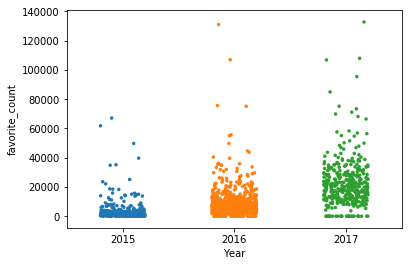

In [66]:
sns.stripplot(x='Year', y='favorite_count', data= twitter_archive_master , jitter=0.2, size=3.5)
axes = plt.gca()

#### Pie chart for most popular dog Stages

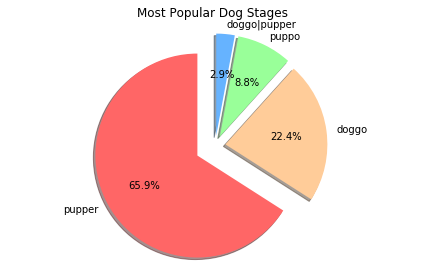

In [67]:
#Pie chart plot for dog stages

dog_stage_count = list(twitter_archive_clean[twitter_archive_clean['dog_stages'] != 'None']['dog_stages'].value_counts())[0:4]
labels = twitter_archive_clean[twitter_archive_clean['dog_stages'] != 'None']['dog_stages'].value_counts().index.tolist()[0:4]
explode = (0.2, 0.1, 0.1, 0.1) 
colors = ['#ff6666', '#ffcc99', '#99ff99', '#66b3ff']

fig1, ax1 = plt.subplots()
ax1.pie(dog_stage_count, explode = explode, labels = labels, colors=colors, autopct='%1.1f%%', shadow = True, startangle = 90)
ax1.set_title('Most Popular Dog Stages')

ax1.axis('equal')
plt.tight_layout()
plt.show()

The most common dog stages is 'Pupper', followed by Doggo, Puppo and then Pupper|Doggo.

#### Group by the dog stages depending on both favorite_count and favorite_count

Text(0,0.5,'count')

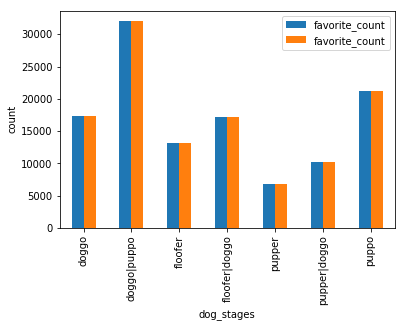

In [401]:
twitter_archive_master.groupby('dog_stages')['favorite_count', 'favorite_count'].mean().plot(kind = 'bar')
plt.ylabel('count')